In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv
/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv
/kaggle/input/osic-pulmonary-fibrosis-progression/sample_submission.csv
/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/137.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/153.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/37.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/167.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/248.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/40.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/206.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/6.dcm
/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140/98.dcm
/kag

In [2]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

In [3]:
# Some constants 
INPUT_FOLDER = '../input/osic-pulmonary-fibrosis-progression/train/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [4]:
patients[0]

'ID00007637202177411956430'

In [5]:
data_path = '../input/osic-pulmonary-fibrosis-progression/train/'+patients[0]
g = glob(data_path + '/*.dcm')
# Print out the all file names to verify we're in the right folder.
print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print ("\n".join(g[:-1]))

Total of 30 DICOM images.
First 5 filenames:
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/6.dcm
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/7.dcm
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/27.dcm
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/28.dcm
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/18.dcm
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/22.dcm
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/1.dcm
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/21.dcm
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/14.dcm
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/9.dcm
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/8.dcm
../input/osic-pulmonary-fibrosis-pro

In [6]:
# Load the scans in given folder path
def load_scan(path):
    slices = [pydicom.read_file(path + "/" + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [7]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    #outside_image = image.min()
    #image[image == outside_image] = 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

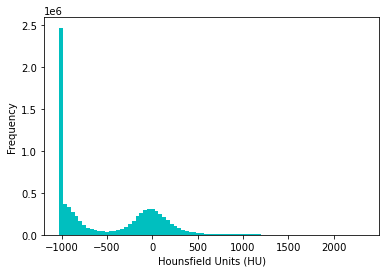

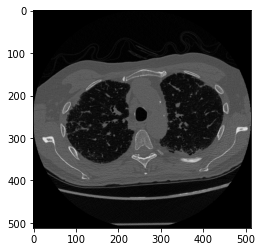

In [8]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[20], cmap=plt.cm.gray)
plt.show()

high frequency at HU=-1000 means that there is lots of air captured in image

In [9]:
len(first_patient_pixels)

30

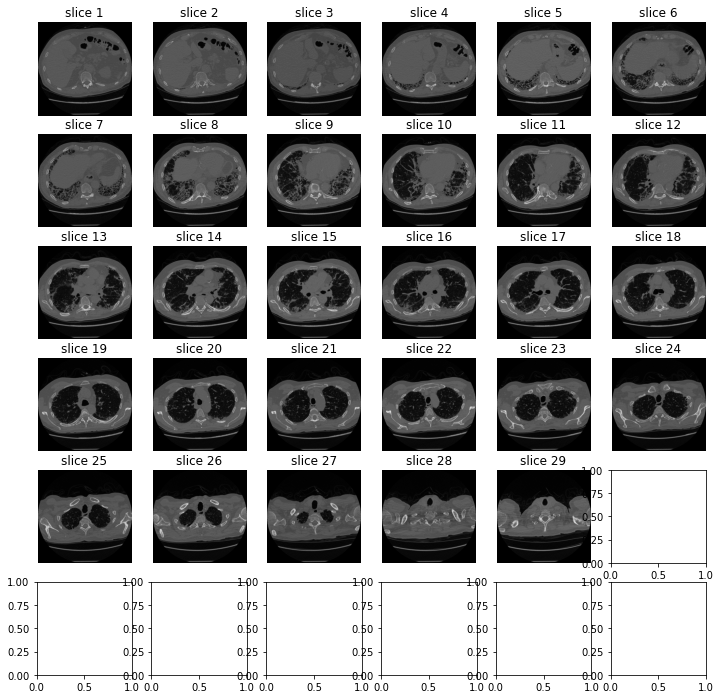

In [10]:
imgs_to_process = first_patient_pixels

def sample_stack(stack, rows=6, cols=6, start_with=1, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    #for i in range(rows*cols):
    i = 0
    while i < len(stack)-1:
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
        i += 1
    plt.show()

sample_stack(imgs_to_process)


In [11]:
print("Slice Thickness: %f" % first_patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (first_patient[0].PixelSpacing[0], first_patient[0].PixelSpacing[1]))

Slice Thickness: 10.000000
Pixel Spacing (row, col): (0.652344, 0.652344) 


In [12]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + [scan[0].PixelSpacing[0]]+ [scan[0].PixelSpacing[1]]))
    #np.array([scan[0].SliceThickness] + [scan[0].PixelSpacing[0]]+ [scan[0].PixelSpacing[1]], dtype=np.float32)
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [13]:
print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, first_patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (30, 512, 512)
Shape after resampling	 (300, 334, 334)


In [14]:
print(spacing)

[1.         1.00000038 1.00000038]


def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    plt.show()

v, f = make_mesh(imgs_after_resamp, 350)
plt_3d(v, f)

In [15]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

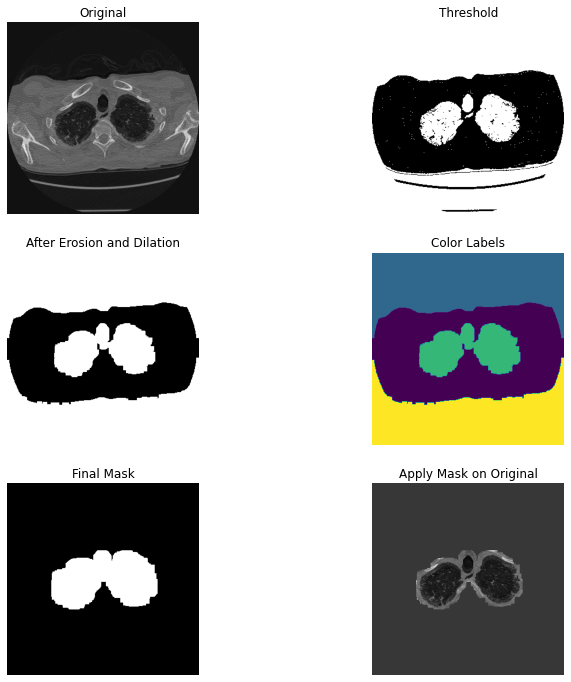

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [16]:
img = imgs_after_resamp[260]
make_lungmask(img, display=True)

IndexError: index 6 is out of bounds for axis 0 with size 6

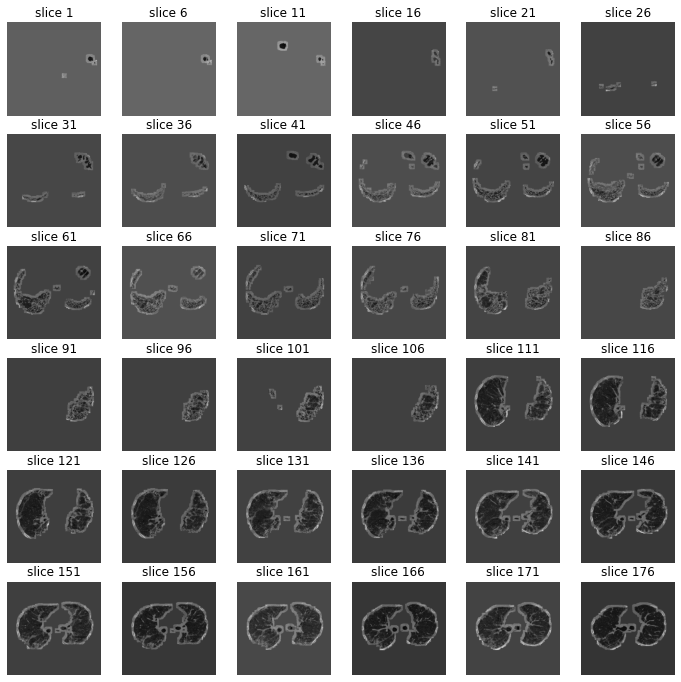

In [17]:
masked_lung = []

for img in imgs_after_resamp:
    masked_lung.append(make_lungmask(img))

sample_stack(masked_lung, show_every=5)

In [18]:
len(masked_lung)

300

In [19]:
print(len(first_patient_pixels))

30


In [20]:
print(imgs_after_resamp)

[[[-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  ...
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]]

 [[-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  ...
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]]

 [[-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  ...
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]]

 ...

 [[-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  ...
  [-1024 -1024 -1024 ... -1024 -1024 -10

In [21]:
np.save("patient_1_processed.npy", imgs_after_resamp)